In [67]:
# TODO scrape any car data from ss.com
# clean up prices as numerics
# group by make and model
# plot the data - pricing for sure

In [33]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
url = "https://www.ss.com/en/transport/cars/bmw/sell/"

In [3]:
req = requests.get(url)
req.status_code

200

In [4]:
soup = BeautifulSoup(req.text, 'lxml')
soup.title

<title>SS.COM Cars - BMW, Prices, Sell - Advertisements</title>

In [5]:
tables = soup.find_all("table")
headline = soup.find("tr", {"id":"head_line"})
headtds = headline.find_all("td")
headline.text
headtds[0].text

'\n\xa0Advertisements\r\n\n\n\ndate\n'

In [6]:
headcolumns = [el.text for el in headtds[1:]]
headcolumns

['Model', 'Year', 'Volume', 'Run', 'Price']

In [8]:
def getColList(soup):
    column_list = ["description","url"] # we decided to that we need these two column names no matter the html
    headline = soup.find("tr", {"id":"head_line"})
    headtds = headline.find_all("td")
    headcolumns = [el.text for el in headtds[1:]] # this will get all column names starting with 2nd in HTML
    column_list += headcolumns
    return column_list

In [9]:
column_names = getColList(soup)
column_names

['description', 'url', 'Model', 'Year', 'Volume', 'Run', 'Price']

In [10]:
trows = soup.find_all('tr')

In [11]:
rows = [row for row in trows if row.get('id',"").startswith("tr_") and not row.get('id',"").startswith("tr_bnr") ]

In [12]:
def getRowList(soup):
    trows = soup.find_all('tr')
    aprows = [row for row in trows if row.get('id',"").startswith("tr_") and not row.get('id',"").startswith("tr_bnr") ]
    return aprows

In [13]:
rows = getRowList(soup)

In [14]:
first_ad = rows[0]

In [15]:
row_tds = first_ad.find_all('td')

In [16]:
def getRow(row,colist=column_names):
    row_tds = row.find_all('td')
    rowDict = {}
    if len(row_tds) < 3: # a little sanity check
        print("Hmm bad row")
        return rowDict
    
    rowDict[colist[0]] = row_tds[2].text # so the big assumption is that we always get description in 3rd column
    rowDict[colist[1]] = "https://ss.com" + row_tds[1].find('a').get('href')
    for td,key in zip(row_tds[3:],colist[2:]): 
        rowDict[key] = td.text
    return rowDict

In [17]:
getRow(rows[6])

{'description': 'Pārdodu e46 Facelift 2.0d 110kw\r\nSvaigi izieta tehniskā apskate nomaksāti vi',
 'url': 'https://ss.com/msg/en/transport/cars/bmw/320/bddiij.html',
 'Model': '320',
 'Year': '2002',
 'Volume': '2.0D',
 'Run': '518 thd.',
 'Price': '2,250  €'}

In [18]:
def getRows(rowlist,colist=column_names):
    return [getRow(row, colist=colist) for row in rowlist]

In [19]:
def getDFfromURL(url):
    
    req = requests.get(url)
    if req.status_code != 200:
        print("Request Fail with", req.status_code)
        return None 
    soup = BeautifulSoup(req.text, 'lxml')
    column_names = getColList(soup)
    rowlist = getRowList(soup)
    rows = getRows(rowlist,colist=column_names)
    return pd.DataFrame(rows, columns=column_names)

In [20]:
cars_bmw = url
idf = getDFfromURL(cars_bmw)
idf.head()

,description,url,Model,Year,Volume,Run,Price
0,"Pardodu tikko ievestu no Vācijas ar jaunu Ta, ...",https://ss.com/msg/en/transport/cars/bmw/325/c...,325,2009,2.5D,256 thd.,"7,200 €"
1,Pārdošanā BMW 320 E91 2012.gada\r\nPusotru gad...,https://ss.com/msg/en/transport/cars/bmw/320/b...,320,2012,2.0D,260 thd.,"9,600 €"
2,"730d x-drive. Pirkts Vācijā pie dīlera, visi d...",https://ss.com/msg/en/transport/cars/bmw/730/c...,730,2018,3.0D,48 thd.,"50,000 €"
3,"BMW X5 (173kw), 239000 km, kārba un dzinējs st...",https://ss.com/msg/en/transport/cars/bmw/x5/al...,X5,2007,3.0D,239 thd.,"9,200 €"
4,"Pārdod BMW 320i, skate nav izieta, jo ir nepie...",https://ss.com/msg/en/transport/cars/bmw/320/b...,320,1993,2.0,318 thd.,"4,100 €"


In [21]:
idf.to_csv("cars_bmw_20221023.csv")

In [22]:
bmw_df = pd.read_csv(r"C:\Users\dovil\Desktop\she goes tech\SGT\cars_bmw_20221023.csv")


In [23]:
bmw_df['Price'] = bmw_df['Price'].str.replace("€","")
bmw_df['Price'] = bmw_df['Price'].str.replace(",","")
bmw_df.Price.head()
bmw_df['Price'] = pd.to_numeric(bmw_df['Price'], errors='coerce')

pd.options.display.float_format = '{:,.2f}'.format
bmw_df['Price'].describe()

count       60.00
mean     7,738.75
std      7,472.79
min      1,490.00
25%      3,490.00
50%      5,220.00
75%     10,062.50
max     50,000.00
Name: Price, dtype: float64

In [44]:
bmw_df.groupby(['Model']).describe()['Price']

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
116,1.00,"5,600.00",NaN,"5,600.00","5,600.00","5,600.00","5,600.00","5,600.00"
120,1.00,"8,995.00",NaN,"8,995.00","8,995.00","8,995.00","8,995.00","8,995.00"
216,1.00,"10,250.00",NaN,"10,250.00","10,250.00","10,250.00","10,250.00","10,250.00"
316,2.00,"6,975.00","4,772.97","3,600.00","5,287.50","6,975.00","8,662.50","10,350.00"
318,3.00,"6,576.67","7,286.60","2,290.00","2,370.00","2,450.00","8,720.00","14,990.00"
320,10.00,"5,234.20","3,973.82","1,999.00","2,400.00","3,795.00","6,225.00","14,303.00"
325,2.00,"5,595.00","2,269.81","3,990.00","4,792.50","5,595.00","6,397.50","7,200.00"
420,1.00,"15,600.00",NaN,"15,600.00","15,600.00","15,600.00","15,600.00","15,600.00"
518,1.00,"3,650.00",NaN,"3,650.00","3,650.00","3,650.00","3,650.00","3,650.00"


In [38]:
bmw_df.groupby(['Year']).describe()['Price']

,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
1984,1.00,"3,650.00",NaN,"3,650.00","3,650.00","3,650.00","3,650.00","3,650.00"
1990,1.00,"2,500.00",NaN,"2,500.00","2,500.00","2,500.00","2,500.00","2,500.00"
1993,1.00,"4,100.00",NaN,"4,100.00","4,100.00","4,100.00","4,100.00","4,100.00"
1995,1.00,"3,600.00",NaN,"3,600.00","3,600.00","3,600.00","3,600.00","3,600.00"
1998,1.00,"2,499.00",NaN,"2,499.00","2,499.00","2,499.00","2,499.00","2,499.00"
1999,1.00,"1,490.00",NaN,"1,490.00","1,490.00","1,490.00","1,490.00","1,490.00"
2000,1.00,"3,990.00",NaN,"3,990.00","3,990.00","3,990.00","3,990.00","3,990.00"
2002,6.00,"3,021.50",660.23,"2,250.00","2,542.50","2,949.50","3,424.75","3,990.00"
2003,3.00,"3,256.67",404.15,"2,790.00","3,140.00","3,490.00","3,490.00","3,490.00"


In [39]:
bmw_df['Run'] = bmw_df['Run'].str.replace("thd.","")
bmw_df['Run'] = pd.to_numeric(bmw_df['Run'], errors='coerce')
bmw_df.groupby(['Year']).describe()['Run']

AttributeError: Can only use .str accessor with string values!

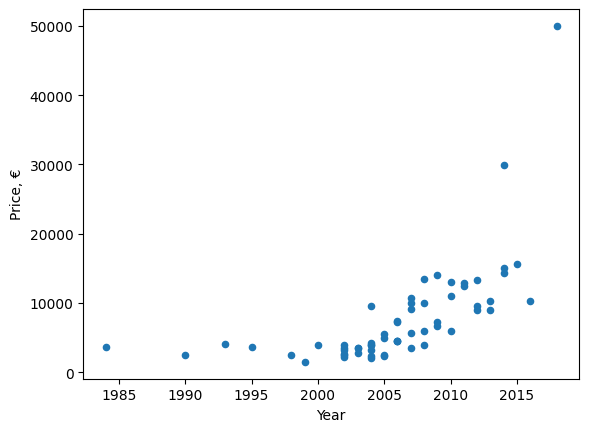

In [40]:

bmw_df_price = bmw_df.sort_values(['Year'], ascending=[True])
bmw_df_price = pd.DataFrame(bmw_df_price,columns=['Year','Price'])
bmw_df_price.plot(x ='Year', y='Price', kind = 'scatter')
plt.ylabel('Price, \u20ac')
plt.show()


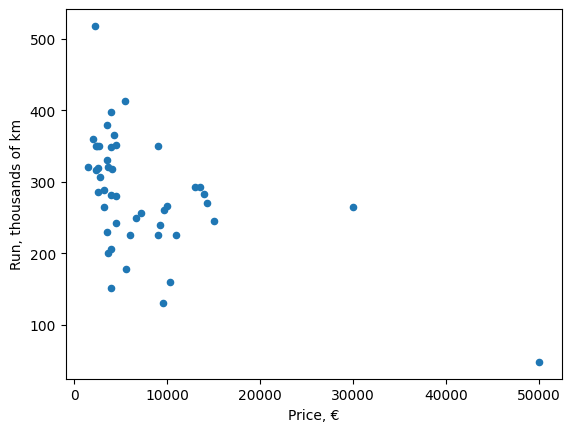

In [41]:
bmw_df_run = bmw_df.sort_values(['Run'], ascending=[True])
bmw_df_run = pd.DataFrame(bmw_df_run,columns=['Run','Price'])
bmw_df_run.plot(x ='Price', y='Run', kind = 'scatter')
plt.ylabel('Run, thousands of km')
plt.xlabel('Price, \u20ac')
plt.show()

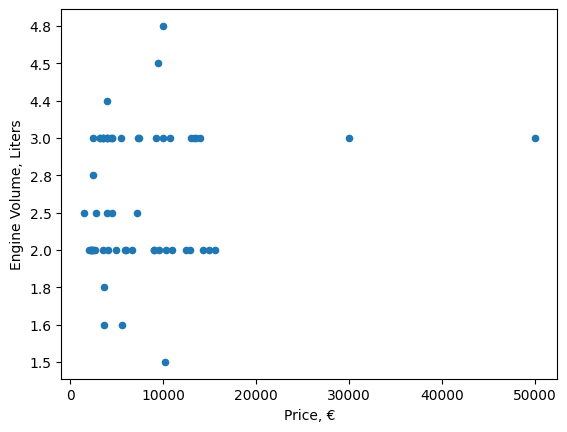

In [42]:
bmw_df['Volume'] = bmw_df['Volume'].str.replace("D","")
bmw_df['Volume'] = bmw_df['Volume'].str.replace("B","")
bmw_df['Volume'] = bmw_df['Volume'].str.replace("H","")
bmw_df_volume = bmw_df.sort_values(['Volume'], ascending=[True])
bmw_df_volume = pd.DataFrame(bmw_df_volume,columns=['Volume','Price'])
bmw_df_volume.plot(x ='Price', y='Volume', kind = 'scatter')
plt.xlabel('Price, \u20ac')
plt.ylabel('Engine Volume, Liters')
plt.show()

Text(0.5, 1.0, 'The median car price, €')

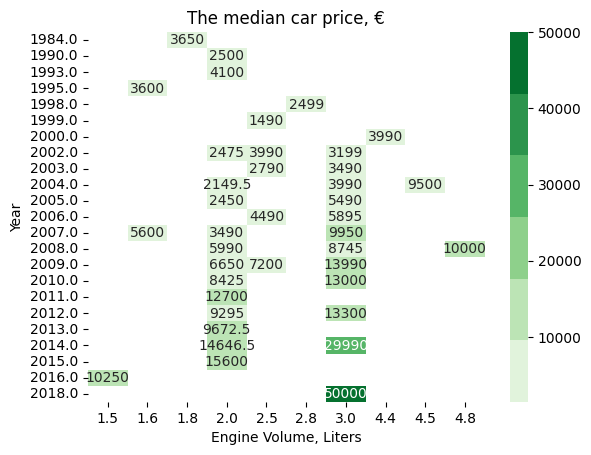

In [43]:
bmw_map = bmw_df[['Year', 'Volume', 'Run', 'Price']]
bmw_map = bmw_map.astype({'Year':'float'})

bmw_table = bmw_map.pivot_table(index='Year', columns='Volume', values='Price', aggfunc=np.median)
bmw_table
plt.figure()
colormap = sns.color_palette("Greens")
ax = sns.heatmap(data=bmw_table, cmap=colormap, annot=True, fmt='g')
ax.set_xlabel('Engine Volume, Liters')
ax.set_title('The median car price, \u20ac')